In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
import json
from src.metric_participants import ComputeMetrics
from pandasql import sqldf
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from datetime import datetime
from itertools import product

makeQuery = lambda q: sqldf(q, globals())

In [2]:
with open('./data/data_files/train_validation_split_5.json', 'r') as f: 
    cvSplit = json.load(f)

In [3]:
referenceDate = datetime.strptime('2020-07', '%Y-%m')
salesOffset = 100
salesTrain = pd.read_csv('./data/data_files/sales_train_splitted.csv', index_col=0)

regions = ['region_{}'.format(i) for i in range(201)]
months = list([datetime.strptime(m, '%Y-%m') for m in set(salesTrain.month.values.tolist())])
months.sort()
months = ['{}-{}'.format(d.year, '0'+str(d.month) if d.month < 10 else d.month) for d in months]
brands = ['brand_1', 'brand_2']

def sortDf(df: pd.DataFrame, isTrain: bool) -> pd.DataFrame: 
    tempRegions = regions[:151] if isTrain else regions[151:]
    df.region = pd.Categorical(df.region, tempRegions)
    df.month = pd.Categorical(df.month, months)
    df.sort_values(['region', 'month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
salesTrain[(salesTrain['region'] == 'region_0') * (salesTrain['brand'] == 'brand_1')]

,month,region,brand,sales
0,2020-01,region_0,brand_1,0.00
905,2020-02,region_0,brand_1,0.00
1810,2020-03,region_0,brand_1,0.00
2715,2020-04,region_0,brand_1,0.00
3620,2020-05,region_0,brand_1,0.00
4525,2020-06,region_0,brand_1,0.00
5430,2020-07,region_0,brand_1,0.00
6335,2020-08,region_0,brand_1,612.44
7240,2020-09,region_0,brand_1,1653.59
8145,2020-10,region_0,brand_1,1898.56


In [5]:
# split by brand and transform time data to columns
def prepareRegionYTrue(salesTrain): 
    transformedData = {}
    for brand in brands: 
        brandData = {}
        for month in months: 
            query = """
            SELECT region, sales
            FROM salesTrain
            WHERE brand = '{brand}'
            AND month = '{month}'
            """.format(brand=brand, month=month)
            df = makeQuery(query)
            df.set_index('region', drop=True, inplace=True)
            brandData[month] = df['sales'].to_dict()
        df = pd.DataFrame.from_dict(brandData, orient='index').sort_index(ascending=True).T
        transformedData[brand] = pd.DataFrame(np.where((df == 0), sys.float_info.epsilon, df.values), index=df.index, columns=df.columns)
    return transformedData

transformedData = prepareRegionYTrue(salesTrain)

In [6]:
transformedData['brand_1'].head()

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
region_0,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,6.124400e+02,1.653590e+03,1898.56,2939.71,4440.19,3888.99,2664.11,5603.83,2572.25,4807.65,3674.64,4225.84,2927.80
region_1,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,7.655500e+02,1286.12,1653.59,1408.61,2021.05,1500.48,1837.32,1377.99,2021.05,2572.25,2204.78,3009.96
region_2,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,91.87,367.46,183.73,704.31,826.79,275.60,734.93,1561.72,1561.72,1469.86,2071.56
region_3,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.756000e+02,643.06,2021.05,275.60,2786.60,1224.88,2021.05,1010.53,2572.25,3858.37,2939.71,2374.68
region_4,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,9.187000e+01,1.500480e+03,459.33,1102.39,2939.71,1194.26,826.79,2572.25,2112.92,2112.92,1653.59,2847.85,2651.60


In [7]:
# def func(x, a, b): 
#     return a * np.log10(x) + b
#def func(x, L ,x0, k, b):
    # code for fitting this sigmoid curve was found here: https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
#    y = L / (1 + np.exp(-k*(x-x0)))+b
#    return (y)
#def func(x, a, b, c, d, e): 
#    return a*x**4 + b*x**3 + c*x**2 + d*x + e
def func(x, a, b, c, d): 
    return a*x**3 + b*x**2 + c*x + d

In [8]:
# fit a linear model on each region -> parameters are target values for prediction model
def fitSalesCurves(transformedData): 
    linearModels = {}
    failedModels = []
    initialGuesses = []
    for brand in brands: 
        # df = transformedData[brand].applymap(lambda x: np.log10(x) if x > 0 else 0)
        df = transformedData[brand]
        regionParameters = {}
        x = np.arange(6, df.shape[1]) # start at july
        for i, row in df.iterrows(): 
            # k, d = np.polyfit(x, row.values[6:], deg=1)
            # regionParameters[i] = {'k': k, 'd': d}
            #make initial guess
            y = row.values[6: ]
            #initialGuess = [max(y), np.median(x),1,min(y)] 
            #initialGuesses.append(initialGuess)
            #bounds = (np.array(initialGuess)/2, np.array(initialGuess)*2)
            try: 
                # fittedParams = curve_fit(func, x, y, initialGuess, method='dogbox', maxfev=10000, bounds=bounds)[0]
                fittedParams = curve_fit(func, x, y, method='dogbox', maxfev=10000)[0]
            except RuntimeError as e: 
                print(i, e)
                temp = pd.DataFrame.from_dict(regionParameters, orient='index')
                # fittedParams = initialGuess
                fittedParams = temp.mean(axis=0).values
                failedModels.append(i)
            regionParameters[i] = {i: p for i, p in enumerate(fittedParams)}
        linearModels[brand] = pd.DataFrame.from_dict(regionParameters, orient='index')
    return linearModels

linearModels = fitSalesCurves(transformedData)

In [9]:
linearModels['brand_1']

,0,1,2,3
region_0,0.450511,-72.608002,1847.618261,-8731.240008
region_1,4.685378,-183.550181,2441.372340,-9313.974366
region_2,0.364704,-2.646535,37.753383,-246.405451
region_3,-0.635400,16.931775,129.444849,-1338.909974
region_4,2.995615,-122.374156,1746.867477,-6826.425228
...,...,...,...,...
region_146,1.549092,-64.825945,929.515552,-3434.735421
region_147,5.171481,-212.512539,2873.622761,-11220.856163
region_148,10.474054,-512.118510,8232.348038,-34355.976860
region_149,4.143983,-143.966760,1727.065242,-6082.071647


In [10]:
def predictSales(x, *params): 
    predictedSales = func(x, *params)
    return np.where(predictedSales < salesOffset, 0, predictedSales)  # consider these values 0


In [11]:
#modelType = LinearRegression
modelType = RandomForestRegressor
modelParams = {
    'n_estimators': 200, 
    'max_depth': 40
    # 'max_depth': 10
    # 'criterion': 'absolute_error'
}
# modelParams = {}
regionTrainFeatures = {brand: pd.read_csv('./data/data_files/region_features/training_{}.csv'.format(brand), index_col=0) for brand in brands}
monthsToPredict = np.arange(6, len(months))
monthColumns = months[6:]

In [12]:
def trainEstimationCrossValidation(): 
    models, scalers = {}, {}
    for fold, splits in cvSplit.items():
        trainingSplit, testSplit = splits['training'], splits['test']
        trainingSplit = ['region_{}'.format(i) for i in trainingSplit]
        testSplit = ['region_{}'.format(i) for i in testSplit]
        print('CV fold:', fold)

        brandModels, brandScalers = {}, {}
        for brand in brands: 
            print(brand)

            # define models and parameters, yTrue and make cross-validation
            modelyTrue = linearModels[brand]
            currentFeatures = regionTrainFeatures[brand]

            xTrain, xTest = currentFeatures.loc[trainingSplit].values, currentFeatures.loc[testSplit].values
            yTrain, yTest = modelyTrue.loc[trainingSplit].values, modelyTrue.loc[testSplit].values 

            # scale x data
            scaler = StandardScaler()
            xTrainScaled = scaler.fit_transform(xTrain)
            xTestScaled = scaler.transform(xTest)

            # train model
            model = modelType(**modelParams)
            model.fit(xTrainScaled, yTrain)

            brandModels[brand] = model
            brandScalers[brand] = scaler

        models[fold] = brandModels
        scalers[fold] = brandScalers
    return models, scalers

In [13]:
estimationCvModels, estimationCvScalers = trainEstimationCrossValidation()

CV fold: 0
brand_1
brand_2
CV fold: 1
brand_1
brand_2
CV fold: 2
brand_1
brand_2
CV fold: 3
brand_1
brand_2
CV fold: 4
brand_1
brand_2


In [14]:
def predictDataWithCvModels(features, models, scalers): 
    # evaluate cv. with each model, predict training data to get ci bounds. calculate score for each run and average
    brandPredictions = {}
    for brand in brands: 
        foldPredictions = {}
        for fold in models.keys(): 
            currentFeatures = features[brand]
            scaler = scalers[str(fold)][brand]
            xTrainScaled = scaler.transform(currentFeatures.values)
            model = models[str(fold)][brand]
            parameters = model.predict(xTrainScaled)
            
            predictedSales = []
            for params in parameters: 
                salesForecasts = predictSales(monthsToPredict, *params)
                predictedSales.append(salesForecasts)
            predictedSales = pd.DataFrame(predictedSales, index=currentFeatures.index)
            foldPredictions[int(fold)] = predictedSales
        brandPredictions[brand] = foldPredictions
    return brandPredictions


def getCiFromCv(predictions: Dict[int, pd.DataFrame], correctionFactor: float = 1) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    """
    Calculate ci bounds, such that 80% of the yTrue points fall within the margin of yPred +- bounds. 
    CI is calculated for each data point
    """
    index = predictions[0].index.values
    stackedPredictions = np.stack([preds.values for preds in predictions.values()], axis=0)  # 3D -> fold, region, month
    # mean = stackedPredictions.mean(axis=0)  # average over folds
    lowerBound = np.percentile(stackedPredictions, 10, axis=0)
    upperBound = np.percentile(stackedPredictions, 90, axis=0)
    return (pd.DataFrame(lowerBound*correctionFactor, index=index), 
            pd.DataFrame(upperBound*correctionFactor, index=index))


def getCiBoundsFromCvData(cvPredictions): 
    cvCiBounds = {brand: getCiFromCv(cvPredictions[brand]) for brand in brands}
    for brand, bounds in cvCiBounds.items(): 
        lower, upper = bounds
        lower.rename(columns={c: monthColumns[c] for c in lower.columns.values}, inplace=True)
        upper.rename(columns={c: monthColumns[c] for c in upper.columns.values}, inplace=True)
    return cvCiBounds

In [15]:
def getSubmissionDataFromSales(predictions: Dict[str, pd.DataFrame], 
                               isTrain: bool = False
                              ) -> pd.DataFrame: 
    """
    Takse a dict for predictions and bounds. In both cases the keys are the brands. 
    The values for predictions are dataframes containing the predictions per region (index) and month (column). 
    The values for the bounds are tuples of two dataframes of lower and upper bounds with same index and 
    columns as the predictions df. 
    Transforms the data into a dataframe with columns, month, region, brand, sales, lower, upper, as required
    by the submission platform.
    """
    submissionData = []
    tempRegions = regions[:151] if isTrain else regions[151:]
    for brand in brands: 
        preds = predictions[brand]
        # lower, upper = bounds[brand]
        for region in tempRegions: 
            for month in months[6:]: 
                row = [month, region, brand, preds.at[region, month]]
                submissionData.append(row)
    submissionData = pd.DataFrame(submissionData, columns=['month', 'region', 'brand', 'sales'])
    # submissionData.sort_values(by=['month', 'region', 'brand'], ascending=True, inplace=True)
    # submissionData.reset_index(drop=True, inplace=True)
    sortDf(submissionData, isTrain)
    return submissionData

In [16]:
trainEstimatedSales = predictDataWithCvModels(regionTrainFeatures, estimationCvModels, estimationCvScalers)
ciBoundsEstimationTrain = getCiBoundsFromCvData(trainEstimatedSales)

In [17]:
def filterBrands(x): 
    return x in ['brand_1', 'brand_2']

def filterMonths(x): 
    d = datetime.strptime(x, '%Y-%m')
    return d >= referenceDate

def scoreEstimationCv(cvPredictions, isTrain):
    accScores, confScores = [], []
    submissions = {}
    # groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)][salesTrain['month'].apply(filterMonths)]
    for i in range(len(cvSplit.keys())): 
        foldData = {}
        for brand in brands: 
            df = cvPredictions[brand][i]
            df.rename(columns={c: monthColumns[c] for c in df.columns.values}, inplace=True)
            foldData[brand] = df

        submissionData = getSubmissionDataFromSales(foldData, isTrain)
        submissionData.rename(columns={'sales': 'sales_estimated'}, inplace=True)
        submissions[i] = submissionData
        
        
        #score = ComputeMetrics(submissionData, 
        #                       salesTrain, 
        #                       groundTruth)
        #accScores.append(score[0])
        #confScores.append(score[1])
        
    # print(np.mean(accScores), np.std(accScores), np.mean(confScores), np.std(confScores))
    return submissions

In [18]:
submissionsTrainEstimation = scoreEstimationCv(trainEstimatedSales, True)

In [19]:
submissionsTrainEstimation[0]

,month,region,brand,sales_estimated
0,2020-07,region_0,brand_1,0.000000
1,2020-07,region_0,brand_2,0.000000
2,2020-08,region_0,brand_1,789.254505
3,2020-08,region_0,brand_2,311.923054
4,2020-09,region_0,brand_1,1622.975798
...,...,...,...,...
4223,2021-06,region_150,brand_2,2344.838010
4224,2021-07,region_150,brand_1,6362.414548
4225,2021-07,region_150,brand_2,2236.341750
4226,2021-08,region_150,brand_1,6483.293659


In [20]:
def plotRandomEstimateRegions(dfTrue, dfPred):
    xTicks = dfTrue.columns.values
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8,8), sharex=True)
    for i in range(4):
        for j in range(4): 
            # yPred = trainingPredictions[brand]
            randomRegion = np.random.randint(0, 151, size=1)[0]
            yPred = dfPred.iloc[randomRegion, :].values
            ax[i, j].plot(dfTrue.columns.values, dfTrue.iloc[randomRegion, :].values)
            ax[i, j].plot(dfTrue.columns.values, np.where(yPred < 0, np.zeros(yPred.shape), yPred))

    plt.setp(ax, 
             xticks=[xTicks[i] for i in range(len(xTicks)) if i%5 == 0], 
            )

    plt.show()
    plt.close()

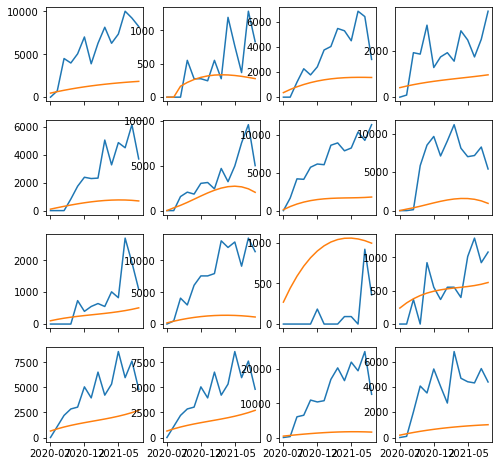

In [21]:
for brand, data in trainEstimatedSales.items(): 
    df = trainEstimatedSales['brand_2'][0]
    dfTrue = transformedData['brand_1']
    columns = [c for c in dfTrue.columns if filterMonths(c)]
    plotRandomEstimateRegions(dfTrue[columns], df)
    break

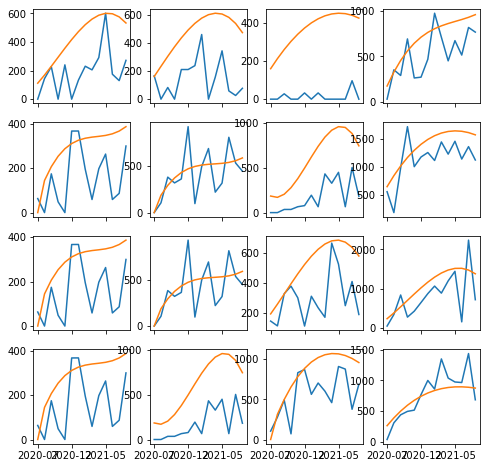

In [22]:
for brand, data in trainEstimatedSales.items(): 
    df = trainEstimatedSales['brand_2'][0]
    dfTrue = transformedData['brand_2']
    columns = [c for c in dfTrue.columns if filterMonths(c)]
    plotRandomEstimateRegions(dfTrue[columns], df)
    break

In [23]:
# load test data
# salesTest = pd.read_csv('./data/data_files/sales_test_splitted.csv', index_col=0)
testRegionFeatures = {brand: pd.read_csv('./data/data_files/region_features/test_{}.csv'.format(brand), index_col=0) for brand in brands}
testRegionFeatures['brand_1'].shape, testRegionFeatures['brand_2'].shape

((50, 26), (50, 19))

In [24]:
testEstimatedCvSales = predictDataWithCvModels(testRegionFeatures, estimationCvModels, estimationCvScalers)
submissionsTestEstimation = scoreEstimationCv(testEstimatedCvSales, False)
submissionsTestEstimation[0]

,month,region,brand,sales_estimated
0,2020-07,region_151,brand_1,0.000000
1,2020-07,region_151,brand_2,142.000273
2,2020-08,region_151,brand_1,175.467538
3,2020-08,region_151,brand_2,225.395690
4,2020-09,region_151,brand_1,416.018686
...,...,...,...,...
1395,2021-06,region_200,brand_2,1446.317148
1396,2021-07,region_200,brand_1,3774.537843
1397,2021-07,region_200,brand_2,1390.852933
1398,2021-08,region_200,brand_1,3812.746317


### Time-based prediction
The idea is to use the previous predictions as a baseline and now train an additional model on top, which predicts a correction on top of the base model. 

In [25]:
# prepare time data

def loadTimeData(isTrain): 
    timeData = {}
    for brand in brands: 
        df = pd.read_csv('./data/data_files/time_features/time_features_{}_{}.csv'.format(brand, 'train' if isTrain else 'test'), index_col=0)
        df = df[df['month'].apply(lambda x: datetime.strptime(x, '%Y-%m') >= referenceDate)]
        sortDf(df, isTrain)
        timeData[brand] = df
    return timeData
        
timeTrain = loadTimeData(True)
timeTrain['brand_1'].head(n=10)

,region,month,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,delta_distinct_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,region_0,2020-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501181.82
1,region_0,2020-08,13.0,10.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478167.37
2,region_0,2020-09,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463424.44
3,region_0,2020-10,-15.0,-6.0,0.0,0.0,-3.0,-3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529006.82
4,region_0,2020-11,-4.0,-4.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522498.60
5,region_0,2020-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,543796.76
6,region_0,2021-01,0.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,505188.62
7,region_0,2021-02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,517642.40
8,region_0,2021-03,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,614682.66
9,region_0,2021-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,609680.12


In [26]:
def mergeEstimationTimeData(estimationCvSubmissions, timeData, isTrain): 
    mergedData = {}
    for fold, submission in estimationCvSubmissions.items(): 
        if 'lower' in submission.columns.values: 
            submission.drop('lower', axis=1, inplace=True)
        if 'upper' in submission.columns.values: 
            submission.drop('upper', axis=1, inplace=True)

        sortDf(submission, isTrain)
        
        foldMerged = {}
        for brand in brands: 
            merged = pd.concat([submission[submission['brand'] == brand].reset_index(drop=True), 
                                timeData[brand].drop(['month', 'region'], axis=1)], 
                               axis=1)
            merged.drop('brand', axis=1, inplace=True)
            foldMerged[brand] = merged
        mergedData[fold] = foldMerged
        
    return mergedData

In [27]:
trainMergedEstimationTimeData = mergeEstimationTimeData(submissionsTrainEstimation, timeTrain, True)
trainMergedEstimationTimeData[0]['brand_1'].head()

,month,region,sales_estimated,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,2020-07,region_0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501181.82
1,2020-08,region_0,789.254505,13.0,10.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478167.37
2,2020-09,region_0,1622.975798,6.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463424.44
3,2020-10,region_0,2339.443621,-15.0,-6.0,0.0,0.0,-3.0,-3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529006.82
4,2020-11,region_0,2942.564373,-4.0,-4.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522498.60


In [28]:
submissionsTestEstimation.keys()

dict_keys([0, 1, 2, 3, 4])

In [29]:
def loadTimeYTrueForBrands():
    loaded = {}
    for brand in brands: 
        df = pd.read_csv('./data/data_files/time_features/sales_delta_{}_train.csv'.format(brand), index_col=0)
        df = df[df['month'].apply(lambda x: datetime.strptime(x, '%Y-%m') >= referenceDate)]
        sortDf(df, True)
        loaded[brand] = df
    return loaded

In [30]:
timeYTrue = loadTimeYTrueForBrands()
timeYTrue['brand_1']

,region,month,sales,delta_sales,rel_delta_sales,prevSales
0,region_0,2020-07,0.00,0.00,0.000000,0.00
1,region_0,2020-08,612.44,612.44,100.000000,0.00
2,region_0,2020-09,1653.59,1041.15,1.700003,612.44
3,region_0,2020-10,1898.56,244.97,0.148144,1653.59
4,region_0,2020-11,2939.71,1041.15,0.548389,1898.56
...,...,...,...,...,...,...
2109,region_150,2021-04,6828.71,1286.13,0.232045,5542.58
2110,region_150,2021-05,6491.86,-336.85,-0.049328,6828.71
2111,region_150,2021-06,5726.31,-765.55,-0.117925,6491.86
2112,region_150,2021-07,8543.54,2817.23,0.491980,5726.31


In [31]:
def trainCvCorrectionModels(xTrain, yTrain, modelType, modelParams): 
    correctionCvModels = {}
    for fold, data in xTrain.items(): 
        
        foldModels = {}
        for brand in brands: 
            split = cvSplit[str(4-fold)]
            trainingSplit, testSplit = split['training'], split['test']
            trainingSplit = ['region_{}'.format(i) for i in trainingSplit]
            # testSplit = ['region_{}'.format(i) for i in testSplit]
            
            print('CV fold:', fold)
            
            currentY = yTrain[brand]
            currentX = xTrain[fold][brand]
            
            y = currentY[currentY['region'].apply(lambda x: x in trainingSplit)]['sales'].values
            x = currentX[currentX['region'].apply(lambda x: x in trainingSplit)]
            
            model = modelType(**modelParams)
            model.fit(x.values[:, 2:], y)
            
            foldModels[brand] = model
        
        correctionCvModels[fold] = foldModels#
    
    return correctionCvModels

In [32]:
#modelType = RandomForestRegressor
#modelParams = {
#    'n_estimators': 100
#}
correctionCvModels = trainCvCorrectionModels(trainMergedEstimationTimeData, timeYTrue, modelType, modelParams)

CV fold: 0
CV fold: 0
CV fold: 1
CV fold: 1
CV fold: 2
CV fold: 2
CV fold: 3
CV fold: 3
CV fold: 4
CV fold: 4


In [33]:
def predictCorrectionCvModels(x, models): 
    predictions = {}
    for fold, data in x.items(): 
        
        brandPredictions = {}
        for brand in brands: 
            model = models[fold][brand]
            
            currentFeatures = x[fold][brand]
            yPred = model.predict(currentFeatures.values[:, 2:])
            yPred = pd.DataFrame(yPred, columns=['sales'], index=currentFeatures.index)
            yPred = pd.concat([currentFeatures[['region', 'month']], yPred], axis=1)
            
            brandPredictions[brand] = yPred
            
        predictions[fold] = brandPredictions
    
    return predictions

In [34]:
correctedTrainPredictions = predictCorrectionCvModels(trainMergedEstimationTimeData, correctionCvModels)

In [35]:
correctedTrainPredictions[0]['brand_1']

,region,month,sales
0,region_0,2020-07,0.00000
1,region_0,2020-08,134.73720
2,region_0,2020-09,1088.53755
3,region_0,2020-10,2407.36760
4,region_0,2020-11,2856.64005
...,...,...,...
2109,region_150,2021-04,6625.88965
2110,region_150,2021-05,6425.71795
2111,region_150,2021-06,5871.73110
2112,region_150,2021-07,7808.34865


In [36]:
def getCiBoundsForCorrectionModels(correctionCvPredictions): 
    ciBounds = {}
    for brand in brands: 
        stacked = []
        for fold, data in correctionCvPredictions.items(): 
            df = data[brand]
            stacked.append(df['sales'].values.reshape(-1, 1))
        stacked = np.concatenate(stacked, axis=1)
        
        lower = pd.DataFrame(np.percentile(stacked, 10, axis=1), columns=['lower'])
        upper = pd.DataFrame(np.percentile(stacked, 90, axis=1), columns=['upper'])
        
        ciBounds[brand] = pd.concat([lower, upper], axis=1)
    return ciBounds

In [37]:
correctedTrainCiBounds = getCiBoundsForCorrectionModels(correctedTrainPredictions)
correctedTrainCiBounds['brand_1']

,lower,upper
0,0.00000,0.00000
1,263.41064,511.20372
2,1112.26577,1549.54611
3,1963.96993,2301.71290
4,2635.41642,2985.49755
...,...,...
2109,6696.94447,6981.64151
2110,6510.94559,6730.69399
2111,6006.00914,6606.31002
2112,7311.15660,8077.43978


In [38]:
def getSubmissionDataFromPredictionsAndCi(correctedCvPredictions, correctedCiBounds): 
    cvSubmissions = {}
    for fold, data in correctedCvPredictions.items(): 
        merged = []
        for brand in brands: 
            df = correctedCvPredictions[fold][brand]
            df['brand'] = brand
            bounds = correctedCiBounds[brand]
            df = pd.concat([df, bounds], axis=1)
            
            merged.append(df)
        
        submission = pd.concat(merged, axis=0)
        cvSubmissions[fold] = submission
            
    return cvSubmissions

In [39]:
correctedTrainCvSubmissions = getSubmissionDataFromPredictionsAndCi(correctedTrainPredictions, correctedTrainCiBounds)

In [40]:
correctedTrainCvSubmissions[0]

,region,month,sales,brand,lower,upper
0,region_0,2020-07,0.00000,brand_1,0.00000,0.00000
1,region_0,2020-08,134.73720,brand_1,263.41064,511.20372
2,region_0,2020-09,1088.53755,brand_1,1112.26577,1549.54611
3,region_0,2020-10,2407.36760,brand_1,1963.96993,2301.71290
4,region_0,2020-11,2856.64005,brand_1,2635.41642,2985.49755
...,...,...,...,...,...,...
2109,region_150,2021-04,1254.91510,brand_2,1172.64695,1635.69922
2110,region_150,2021-05,1442.60070,brand_2,1034.03453,2733.08646
2111,region_150,2021-06,2114.78500,brand_2,1701.87387,2174.15236
2112,region_150,2021-07,1117.12745,brand_2,1154.85853,1372.73299


In [41]:
def scoreCorrectCv(submissions): 
    accScores, confScores = [], []
    
    groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)].copy()
    groundTruth = groundTruth[groundTruth['month'].apply(filterMonths)]
    
    for fold, data in submissions.items(): 
        score = ComputeMetrics(data, salesTrain, groundTruth)
        accScores.append(score[0])
        confScores.append(score[1])
        
    print('Average accuracy score', np.mean(accScores))
    print('Average confidence score', np.mean(confScores))
    return accScores, confScores

In [42]:
accScores, confScores = scoreCorrectCv(correctedTrainCvSubmissions)
accScores, confScores

Average accuracy score 14.212877291046121
Average confidence score 56.43958583611659


([13.145432159676705,
  13.999646525026435,
  16.125487594387742,
  14.216648531474807,
  13.577171644664915],
 [56.439585836116585,
  56.439585836116585,
  56.439585836116585,
  56.439585836116585,
  56.439585836116585])

In [43]:
def getAverageSubmission(submissions): 
    sales = []
    for fold, data in submissions.items(): 
        sales.append(data['sales'].values.reshape(-1, 1))
    
    sales = np.concatenate(sales, axis=1)
    meanSales = np.mean(sales, axis=1)
    finalSubmission = submissions[0].copy()
    finalSubmission.drop('sales', axis=1, inplace=True)
    finalSubmission['sales'] = meanSales
    return finalSubmission

In [44]:
finalTrainSubmission = getAverageSubmission(correctedTrainCvSubmissions)
finalTrainSubmission.head()

,region,month,brand,lower,upper,sales
0,region_0,2020-07,brand_1,0.00000,0.00000,0.00000
1,region_0,2020-08,brand_1,263.41064,511.20372,412.35593
2,region_0,2020-09,brand_1,1112.26577,1549.54611,1294.77935
3,region_0,2020-10,brand_1,1963.96993,2301.71290,2113.86889
4,region_0,2020-11,brand_1,2635.41642,2985.49755,2770.60387


In [45]:
accScores, confScores = scoreCorrectCv({0: finalTrainSubmission})
accScores, confScores

Average accuracy score 12.718662114548014
Average confidence score 56.439585836116585


([12.718662114548014], [56.439585836116585])

In [46]:
def plotRandomRegions(submissionData: pd.DataFrame, 
                      brand: str, 
                      isTrain: bool = False, 
                      groundTruth: pd.DataFrame = None
                     ): 
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), sharex=True)
    for i in range(4): 
        for j in range(4): 
            if isTrain: 
                randomRegion = 'region_{}'.format(np.random.randint(151))
            else: 
                randomRegion = 'region_{}'.format(np.random.randint(151, 201, 1)[0])
            df = submissionData[submissionData['brand'] == brand]
            df = df[df['region'] == randomRegion]
            sales, lower, upper = df['sales'].values, df['lower'].values, df['upper'].values
            ax[i, j].plot(df['month'].values, sales, 'r--')
            ax[i, j].plot(df['month'].values, lower, 'b--')
            ax[i, j].plot(df['month'].values, upper, 'b--')
            
            if groundTruth is not None: 
                df = groundTruth[groundTruth['brand'] == brand]
                df = df[df['region'] == randomRegion]
                ax[i, j].plot(df['month'].values, df['sales'].values, 'g--')
            
    plt.setp(ax, 
             xticks=[df['month'].values[i] for i in range(df.shape[0]) if i%5 == 0], 
            )
    
    plt.show()
    plt.close()
    

In [47]:
groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)].copy()
groundTruth = groundTruth[groundTruth['month'].apply(filterMonths)]

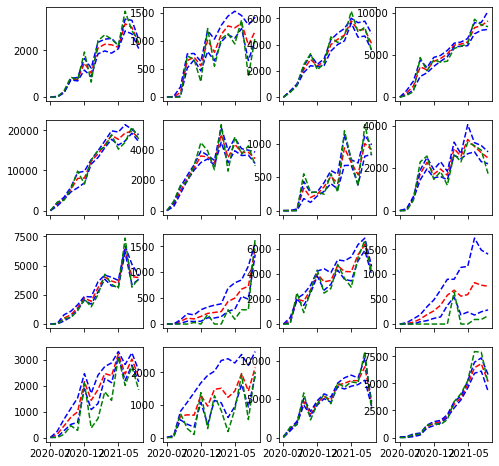

In [48]:
plotRandomRegions(finalTrainSubmission, 'brand_1', True, groundTruth)

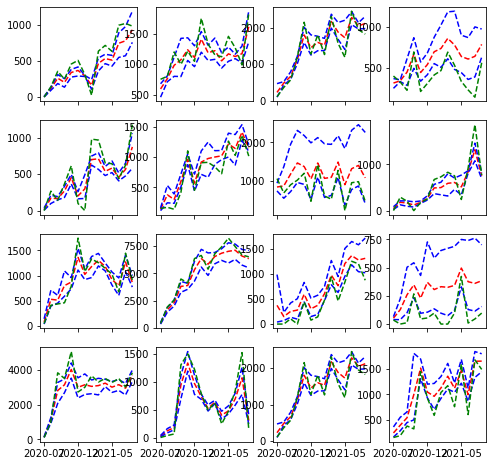

In [49]:
plotRandomRegions(finalTrainSubmission, 'brand_2', True, groundTruth)

In [50]:
# predict test data
timeTest = loadTimeData(False)
timeTest['brand_1'].head(n=10)

,region,month,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,delta_distinct_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,region_151,2020-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212777.53
1,region_151,2020-08,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,166766.21
2,region_151,2020-09,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,-3.0,-1.0,-3.0,-3.0,0.0,0.0,0.0,0.0,196588.63
3,region_151,2020-10,-3.0,-1.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221102.67
4,region_151,2020-11,-6.0,-4.0,0.0,0.0,-1.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188318.94
5,region_151,2020-12,0.0,0.0,0.0,0.0,-2.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226453.77
6,region_151,2021-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190923.73
7,region_151,2021-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193173.29
8,region_151,2021-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226620.01
9,region_151,2021-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235207.48


In [51]:
testMergedEstimationTimeData = mergeEstimationTimeData(submissionsTestEstimation, timeTest, False)
testMergedEstimationTimeData[0]['brand_1'].head()

,month,region,sales_estimated,delta_interactions_1_f2f,delta_distinct_interactions_1_f2f,delta_interactions_1_other,delta_distinct_interactions_1_other,delta_interactions_1_phone,delta_distinct_interactions_1_phone,delta_interactions_1_video,...,delta_distinct_interactions_2_video,delta_nr_contacts_1,delta_hcp_contacted_1,delta_mails_opened_1,delta_mails_clicked_1,delta_nr_contacts_2,delta_hcp_contacted_2,delta_mails_opened_2,delta_mails_clicked_2,market_potential
0,2020-07,region_151,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212777.53
1,2020-08,region_151,175.467538,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,166766.21
2,2020-09,region_151,416.018686,5.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,-3.0,-1.0,-3.0,-3.0,0.0,0.0,0.0,0.0,196588.63
3,2020-10,region_151,682.006605,-3.0,-1.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221102.67
4,2020-11,region_151,963.573224,-6.0,-4.0,0.0,0.0,-1.0,-2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188318.94


In [52]:
correctedTestPredictions = predictCorrectionCvModels(testMergedEstimationTimeData, correctionCvModels)
correctedTestPredictions[0]['brand_1']

,region,month,sales
0,region_151,2020-07,0.00000
1,region_151,2020-08,9.18670
2,region_151,2020-09,428.24870
3,region_151,2020-10,617.80070
4,region_151,2020-11,522.10545
...,...,...,...
695,region_200,2021-04,2047.41480
696,region_200,2021-05,3553.01500
697,region_200,2021-06,3841.54665
698,region_200,2021-07,3473.79255


In [53]:
correctedTestCiBounds = getCiBoundsForCorrectionModels(correctedTestPredictions)
correctedTestCiBounds['brand_1']

,lower,upper
0,0.00000,0.00000
1,3.30726,14.88256
2,167.96215,457.73816
3,476.05019,797.81537
4,618.10725,1232.37868
...,...,...
695,2438.37562,3668.59259
696,2017.04611,4377.37742
697,2665.99407,4113.65112
698,2542.63210,5060.51335


In [54]:
correctedCvSubmissions = getSubmissionDataFromPredictionsAndCi(correctedTestPredictions, correctedTestCiBounds)

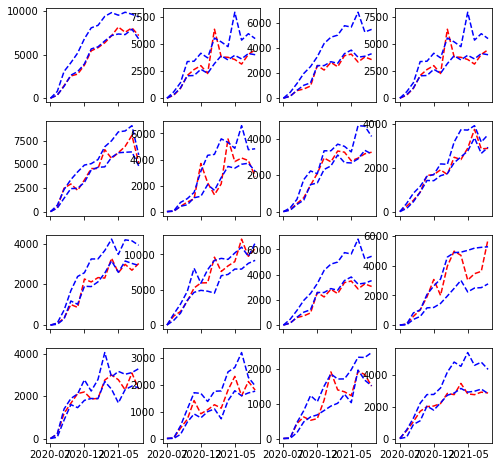

In [55]:
plotRandomRegions(correctedCvSubmissions[0], 'brand_1', False)

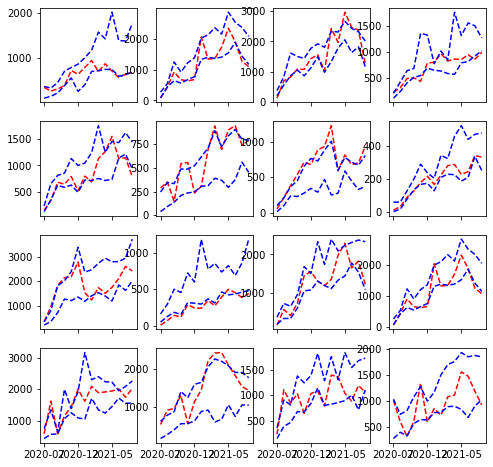

In [56]:
plotRandomRegions(correctedCvSubmissions[0], 'brand_2', False)

In [57]:
finalSubmission = getAverageSubmission(correctedCvSubmissions) 

In [58]:
finalSubmission

,region,month,brand,lower,upper,sales
0,region_151,2020-07,brand_1,0.00000,0.00000,0.00000
1,region_151,2020-08,brand_1,3.30726,14.88256,8.91115
2,region_151,2020-09,brand_1,167.96215,457.73816,317.67321
3,region_151,2020-10,brand_1,476.05019,797.81537,653.74393
4,region_151,2020-11,brand_1,618.10725,1232.37868,916.06800
...,...,...,...,...,...,...
695,region_200,2021-04,brand_2,899.31119,1761.00322,1260.85321
696,region_200,2021-05,brand_2,839.10519,1935.37897,1326.75065
697,region_200,2021-06,brand_2,682.39860,1853.41340,1193.80497
698,region_200,2021-07,brand_2,903.25321,1880.34762,1361.56093


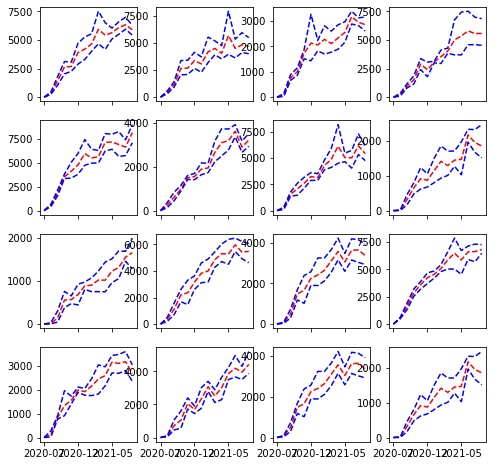

In [59]:
plotRandomRegions(finalSubmission, 'brand_1', False)

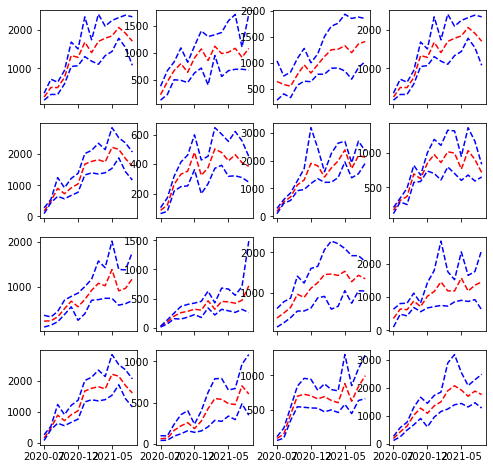

In [60]:
plotRandomRegions(finalSubmission, 'brand_2', False)

In [61]:
finalSubmission.to_csv('./data/data_files/submissions/correction_cv_model_2.csv', index=False)

In [62]:
def gridSearch(modelType, parameters):
    timeData = loadTimeData(True)
    timeYTrue = loadTimeYTrueForBrands()
    
    scores = {}
    for i, modelParams in enumerate(parameters): 
        print(json.dumps(modelParams))
        
        # estimation model
        estimationCvModels, estimationCvScalers = trainEstimationCrossValidation()
        trainEstimatedSales = predictDataWithCvModels(regionTrainFeatures, estimationCvModels, estimationCvScalers)
        ciBoundsEstimationTrain = getCiBoundsFromCvData(trainEstimatedSales)
        submissionsTrainEstimation = scoreEstimationCv(trainEstimatedSales, True)
        
        # correctionModel
        trainMergedEstimationTimeData = mergeEstimationTimeData(submissionsTrainEstimation, timeTrain, True)
        correctionCvModels = trainCvCorrectionModels(trainMergedEstimationTimeData, timeYTrue, modelType, modelParams)
        correctedTrainPredictions = predictCorrectionCvModels(trainMergedEstimationTimeData, correctionCvModels)
        correctedTrainCiBounds = getCiBoundsForCorrectionModels(correctedTrainPredictions)
        correctedTrainCvSubmissions = getSubmissionDataFromPredictionsAndCi(correctedTrainPredictions, correctedTrainCiBounds)
        accScores, confScores =  scoreCorrectCv(correctedTrainCvSubmissions)
        scores[i] = {
            'accuracy': np.mean(accScores), 
            'confidence': np.mean(confScores), 
            **modelParams
        }
        
        print('\n')
    return scores

In [63]:
parametersToTest = {
    'n_estimators': [50, 100, 200], 
    'max_features': ['auto', 'sqrt'], 
    'max_depth': [20, 30, 40]
}
keys = sorted(parametersToTest.keys())
combinations = product(*(parametersToTest[k] for k in keys))
combinedParameters = [{keys[k]: values[k] for k in range(len(keys))} for values in combinations]  # all parameters
combinedParameters

[{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 50},
 {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100},
 {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200},
 {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50},
 {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100},
 {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200},
 {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 50},
 {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 100},
 {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200},
 {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 50},
 {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100},
 {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200},
 {'max_depth': 40, 'max_features': 'auto', 'n_estimators': 50},
 {'max_depth': 40, 'max_features': 'auto', 'n_estimators': 100},
 {'max_depth': 40, 'max_features': 'auto', 'n_estimators': 200},
 {'max_depth': 40, 'max_featur

In [64]:
evaluatedScores = pd.DataFrame.from_dict(evaluatedScores, orient='index')
evaluatedScores.sort_values('accuracy', ascending=True, inplace=True)
evaluatedScores

NameError: name 'evaluatedScores' is not defined